This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7', 'KLRB1'],
    'B Cell': ['CD79A', 'MS4A1'],
    'Plasma': ['IGJ'],
    'CD4 T': ['IL7R'],
    'CD8 T': ['CD8A', 'CD8B'],
    'Megakaryocytes': ['PPBP']
}


genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B cell)'],
    'CD79A': ['CD79A (B cell)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [3]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/pbmc68k/hg19/"

results_file = f"{data_path}/pbmc68k.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.obs['bulk_labels'] = pd.read_csv(f"{data_path}/zheng17_bulk_lables.txt", header=None)[0].values

... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc68k-..-..-data-single_cell_data-pbmc68k-hg19-matrix.h5ad


## Preprocessing

In [4]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 68579 × 32738
    obs: 'bulk_labels'
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


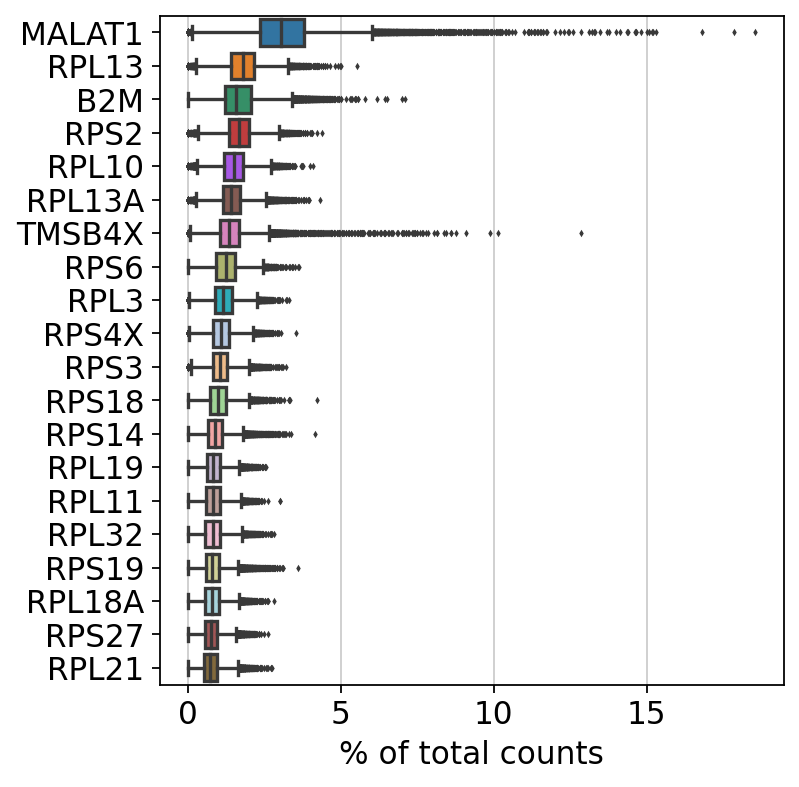

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [6]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)


filtered out 27818 cells that have less than 500 genes expressed
filtered out 16682 genes that are detected in less than 5 cells


... storing 'bulk_labels' as categorical


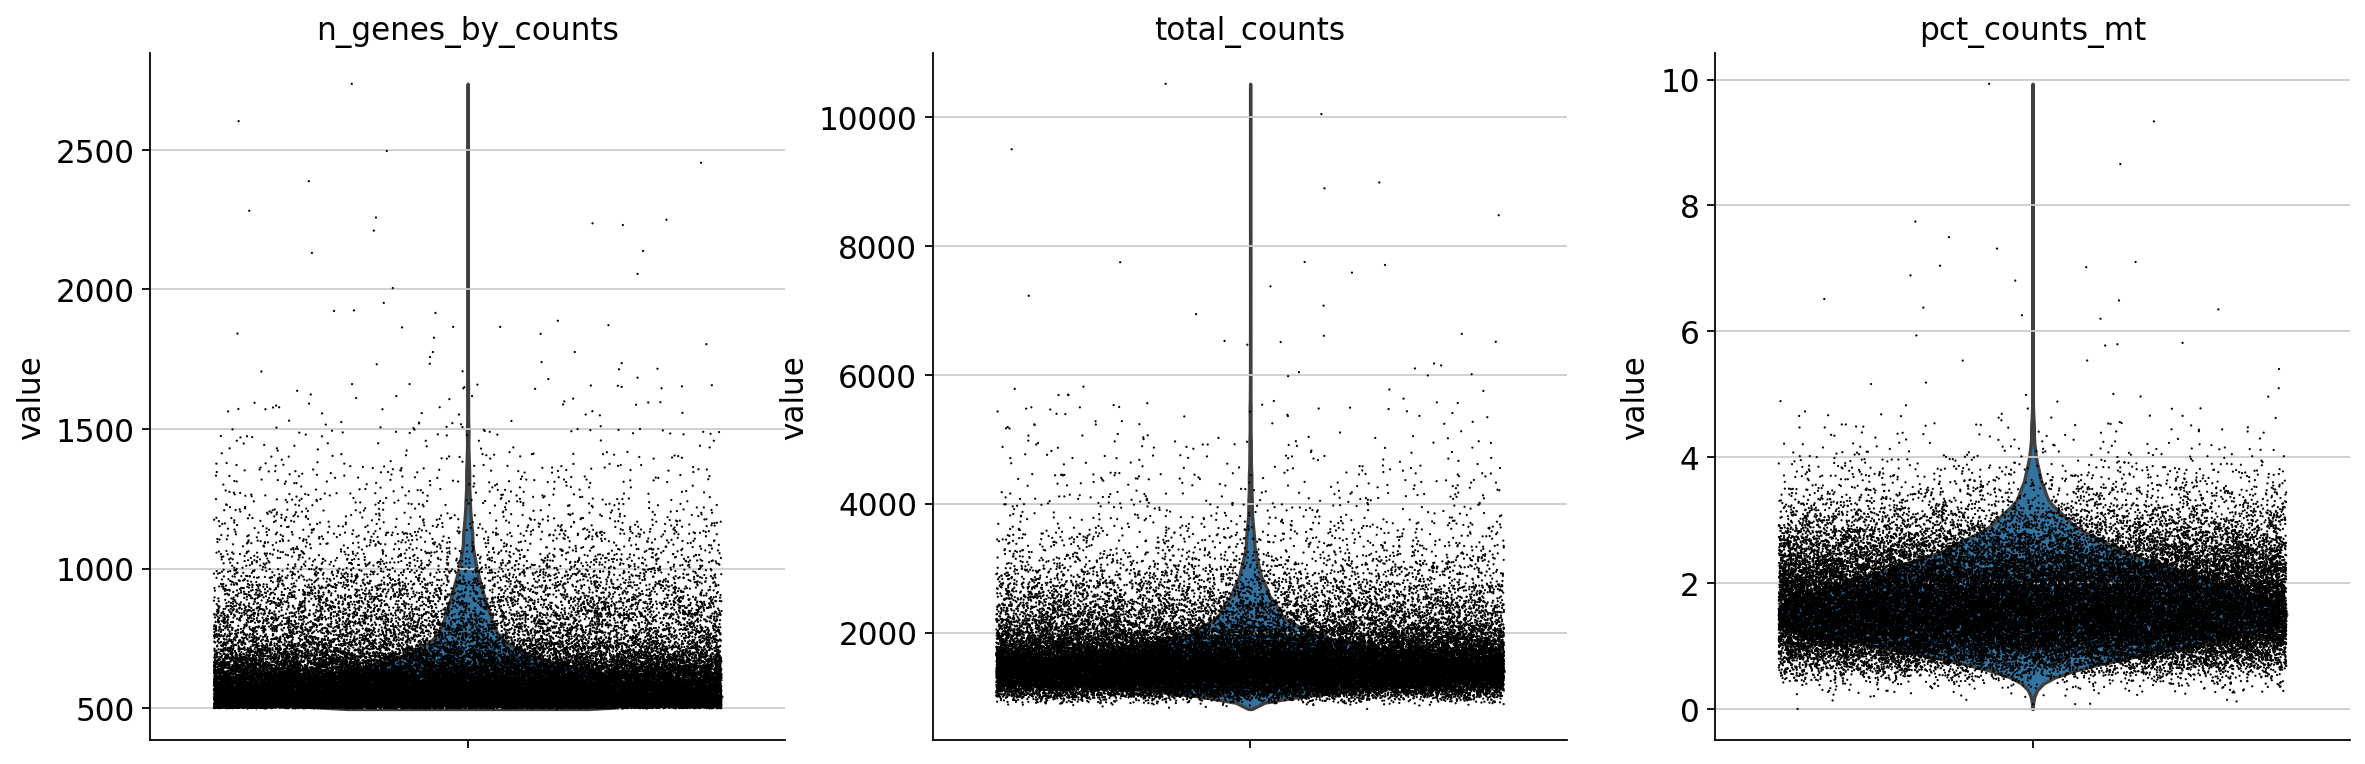

In [7]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

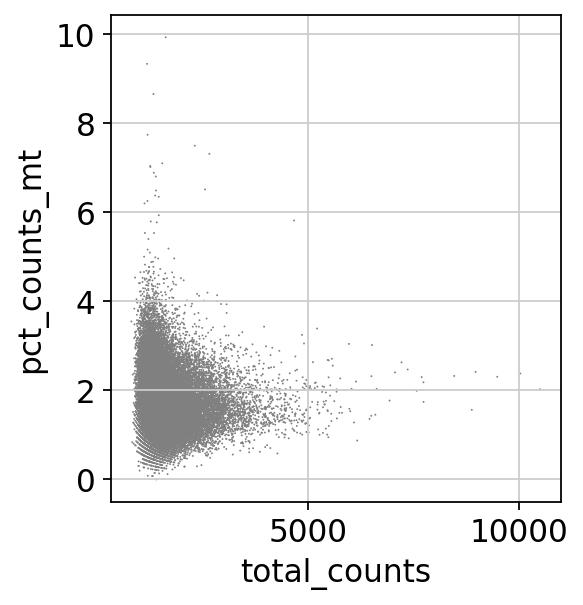

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 1500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


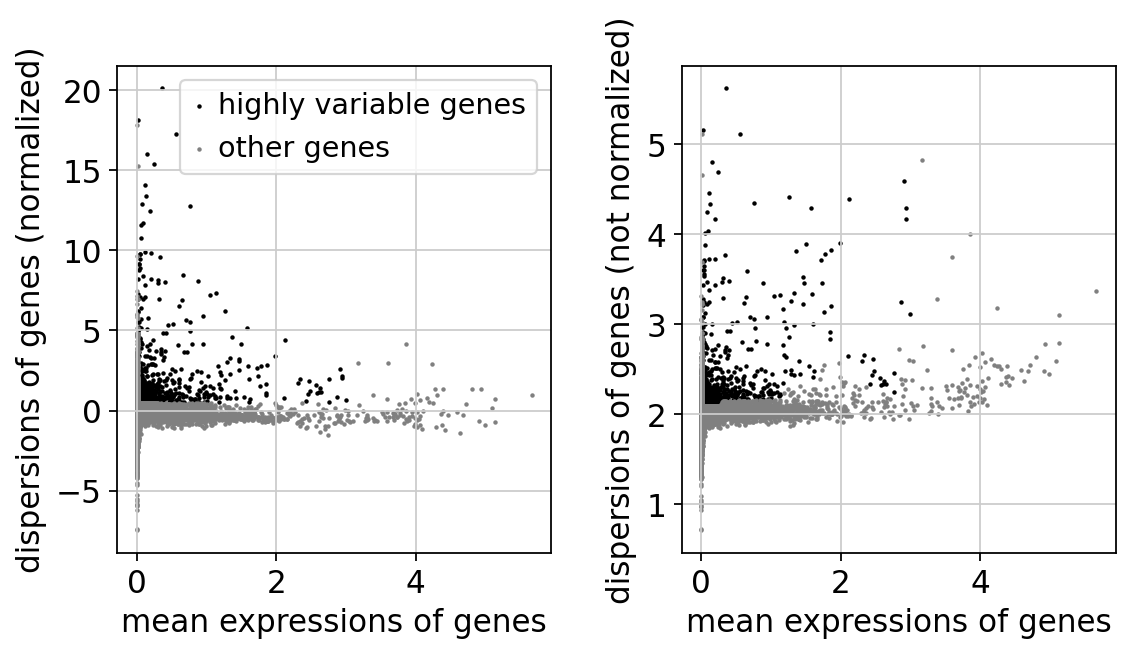

In [ ]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)


In [ ]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:00)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)


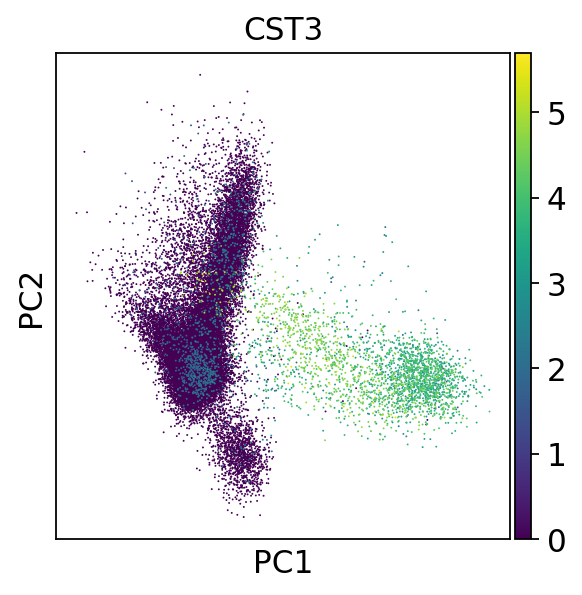

In [ ]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color='CST3')


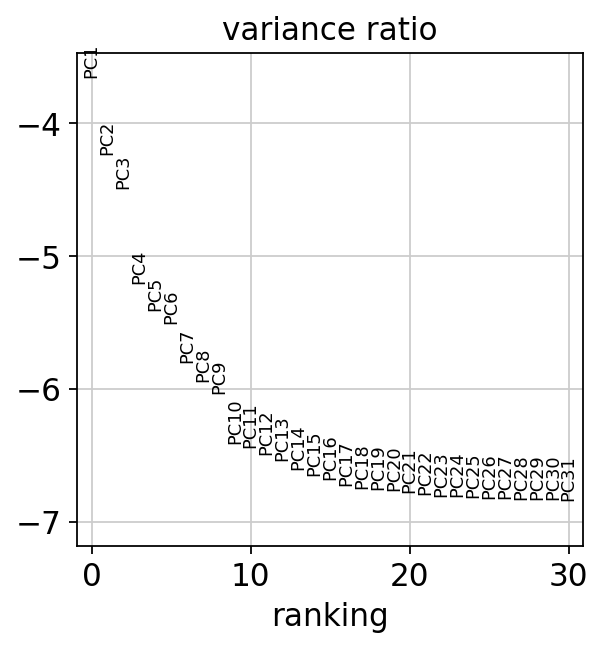

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)


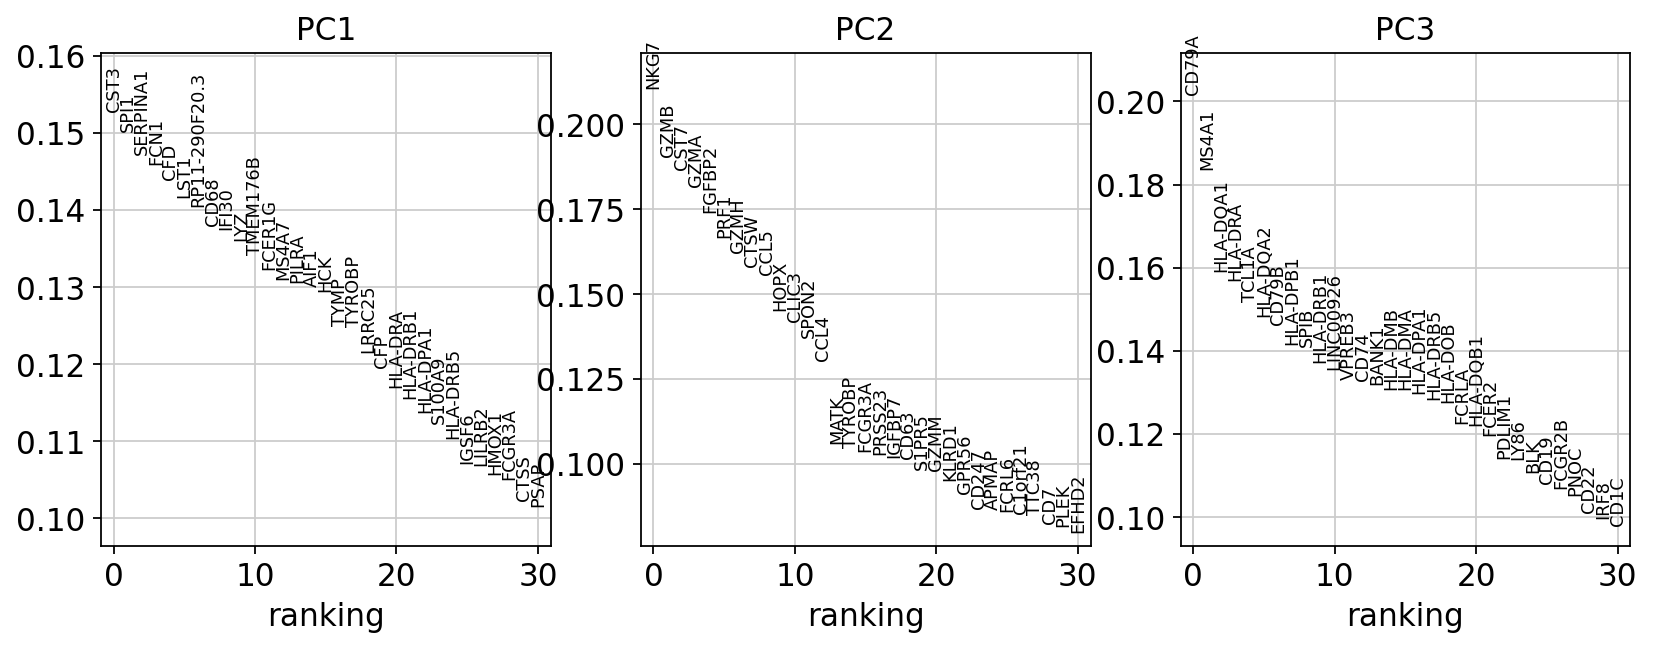

In [ ]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [ ]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [ ]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:57)


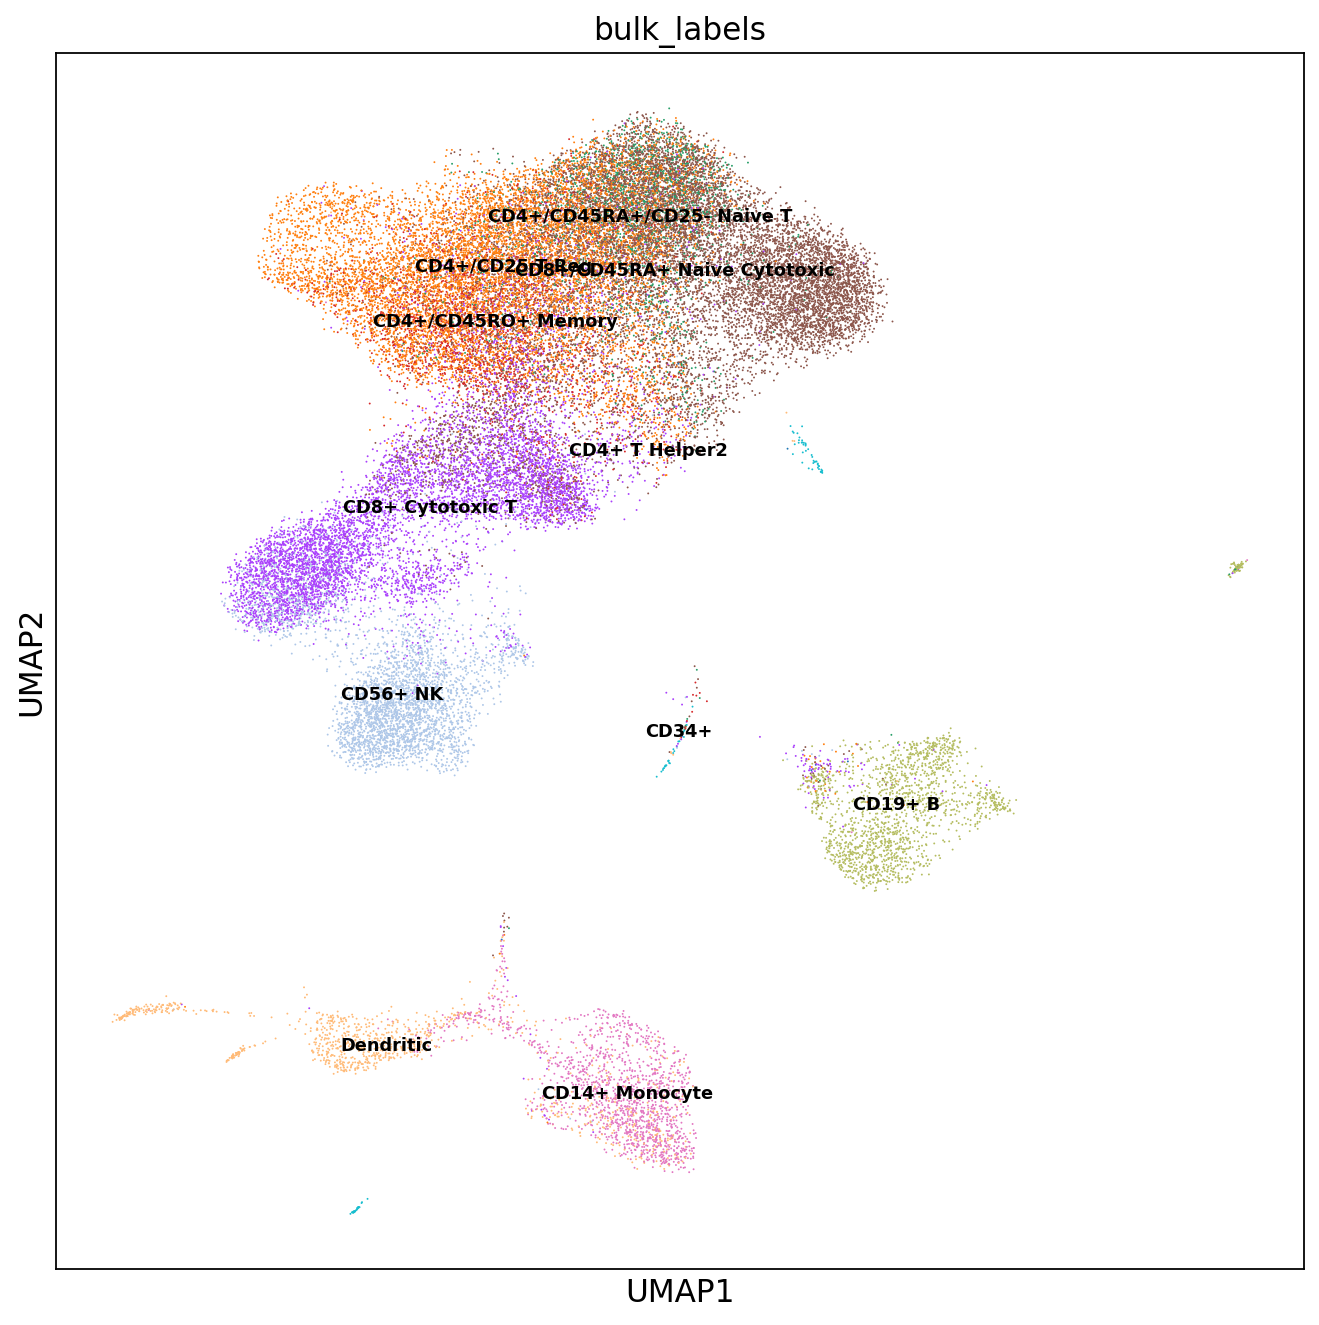

In [ ]:
# plot some markers of the RAW data
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, legend_loc='on data', color='bulk_labels', legend_fontsize=8)

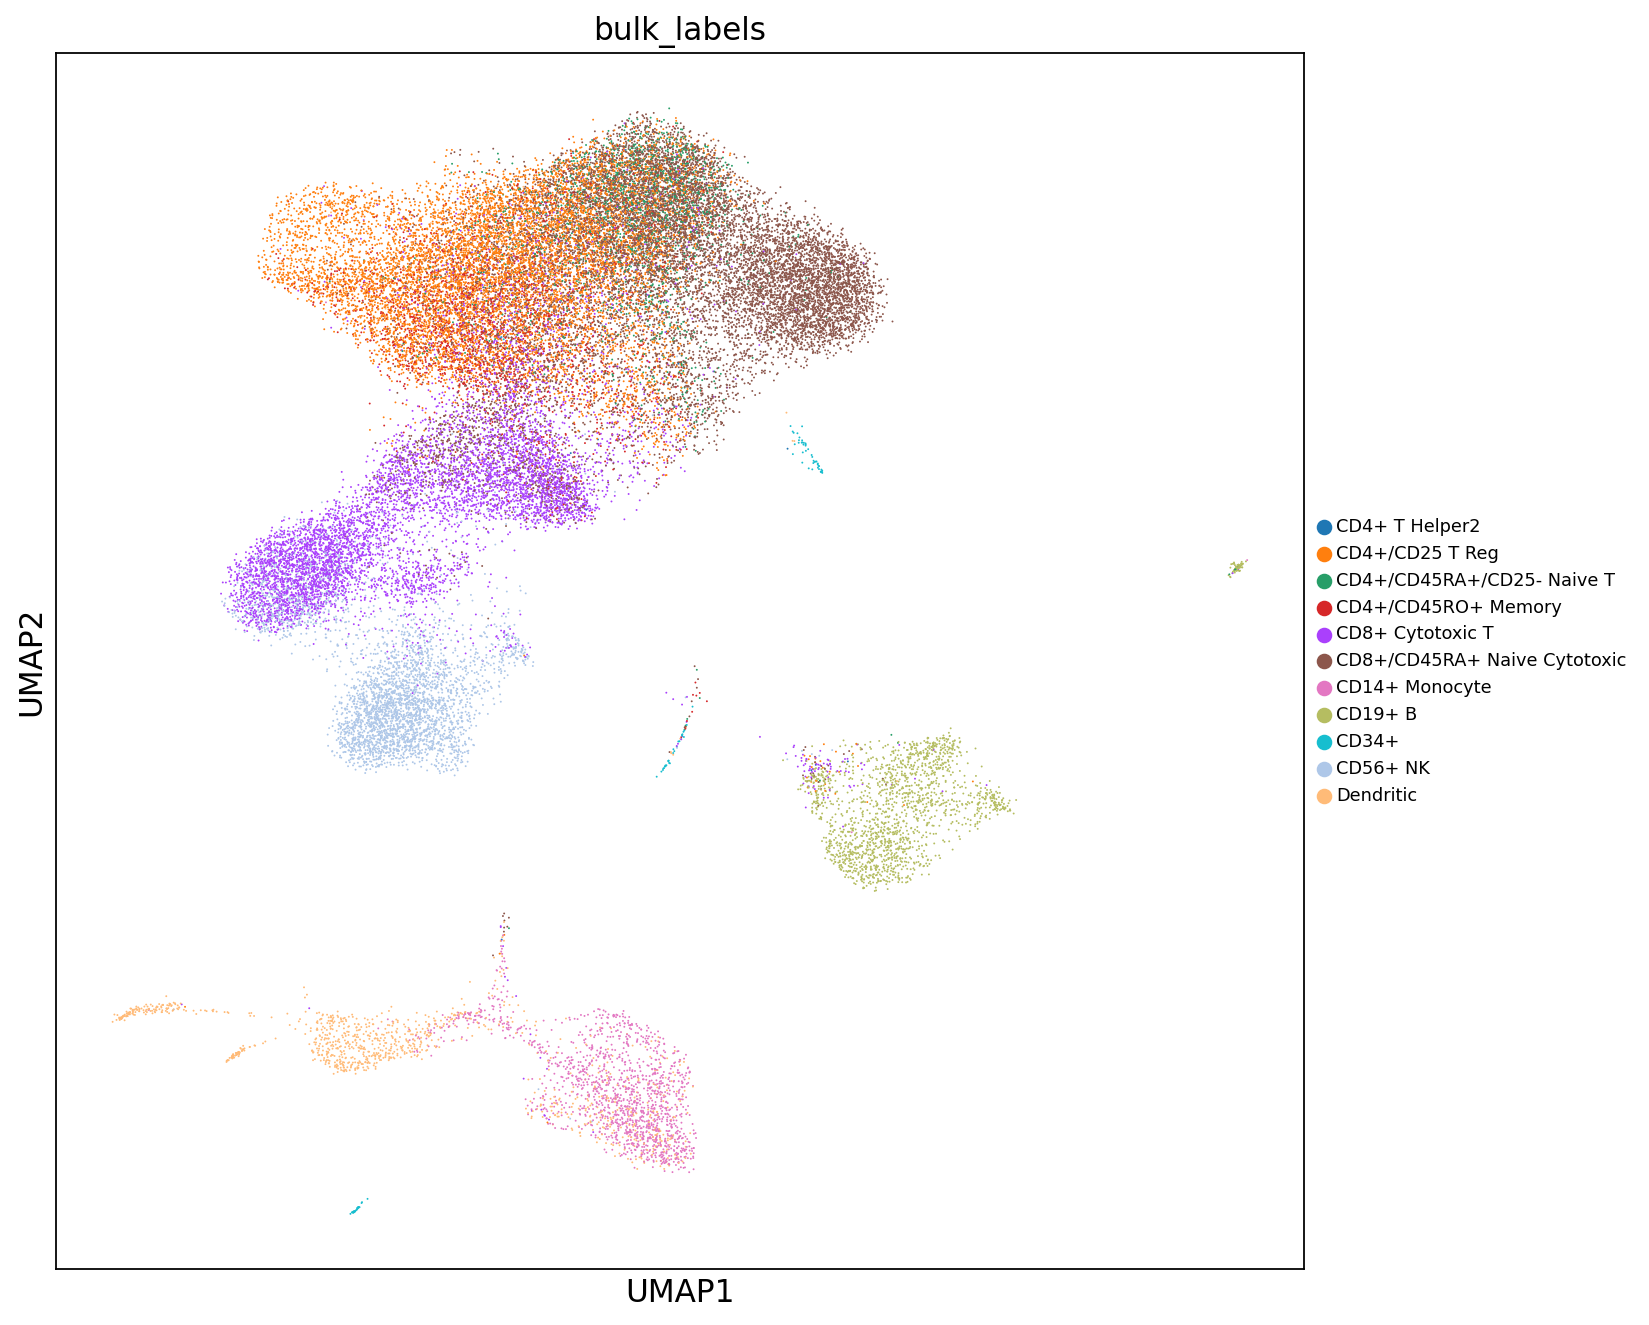

In [ ]:
# plot some markers of the RAW data
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='bulk_labels', legend_fontsize=8)

## Cluster the neighborhood graph

In [ ]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=0.5)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

# save
adata.write(results_file)


NameError: name 'sc' is not defined

categories: CD4+ T Helper2, CD4+/CD25 T Reg, CD4+/CD45RA+/CD25- Naive T, etc.
var_group_labels: CD14 Mono, CD16 Mono, Dendritic, etc.


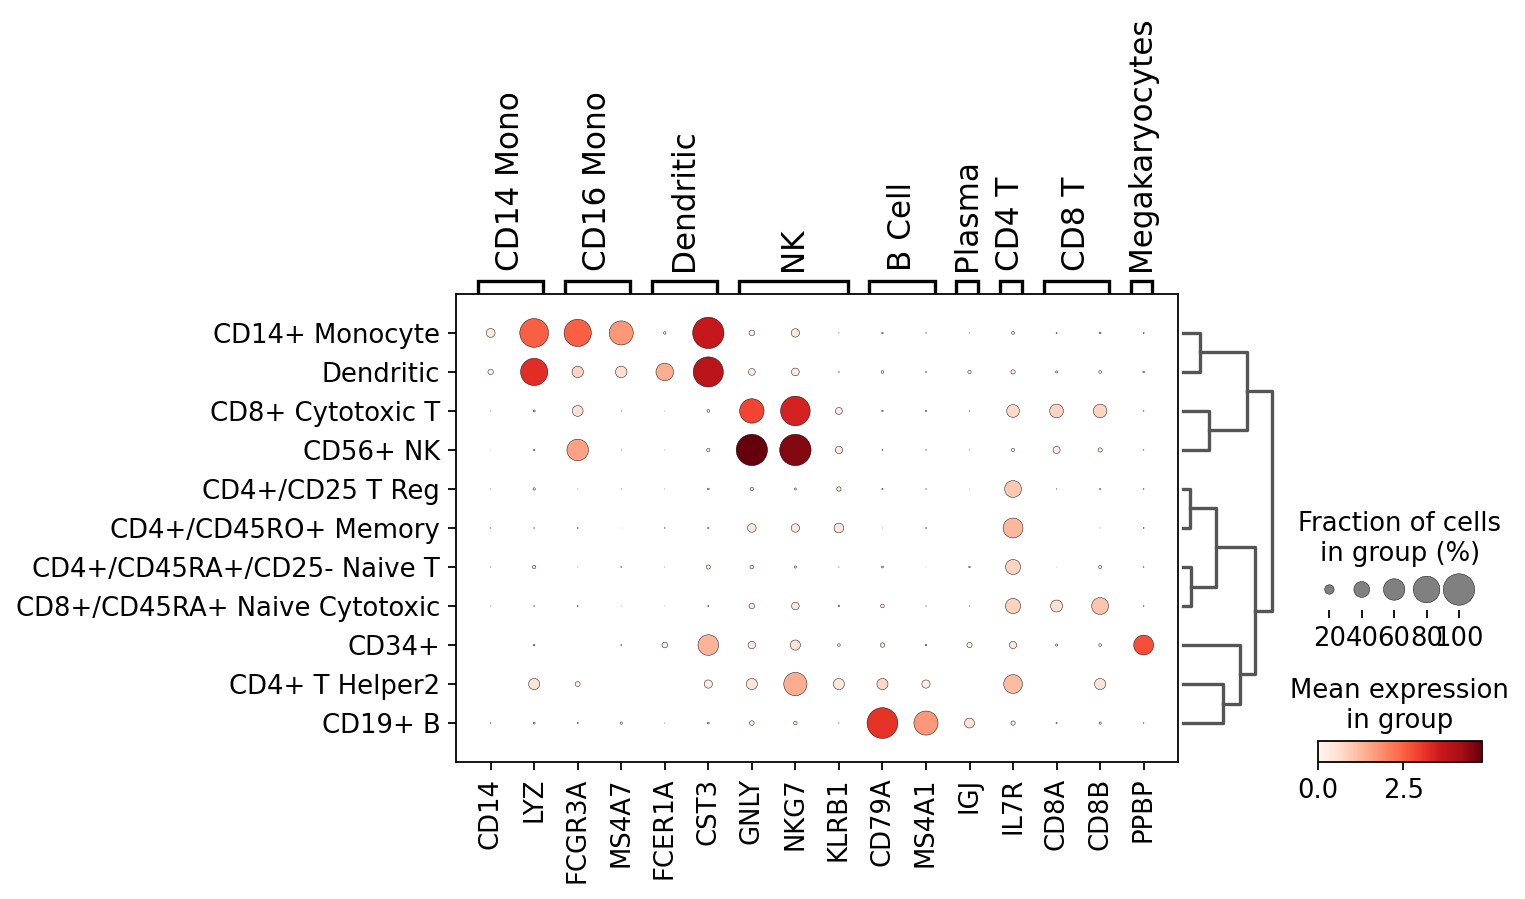

In [199]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='bulk_labels', dendrogram=True)


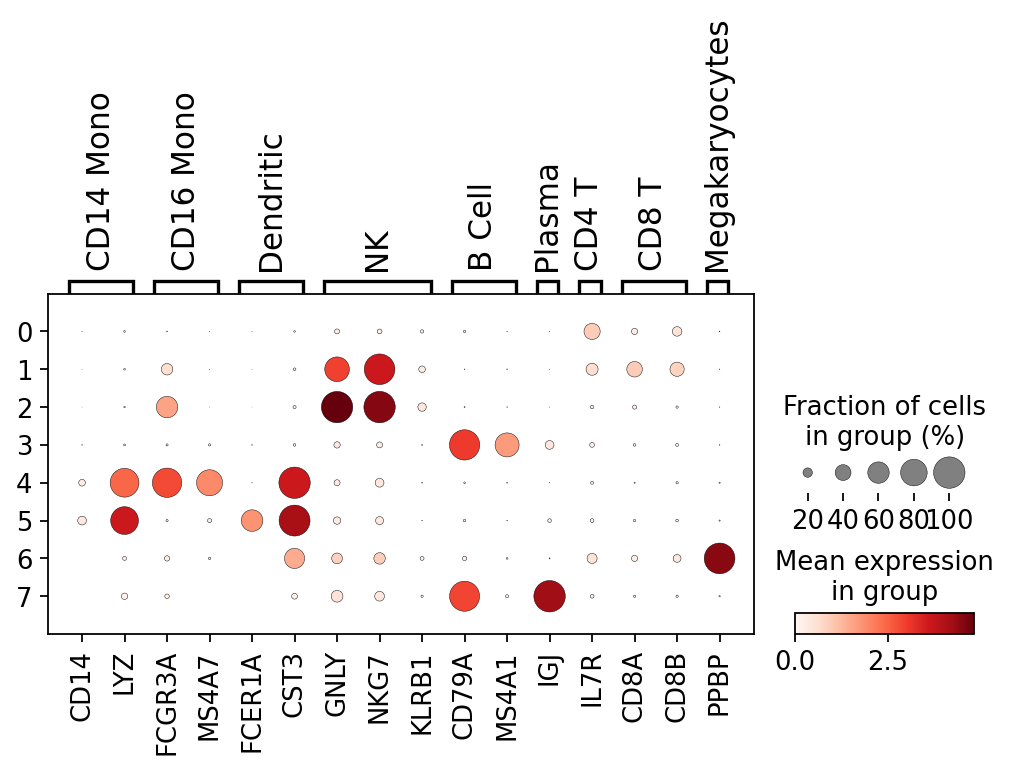

In [205]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', dendrogram=False)


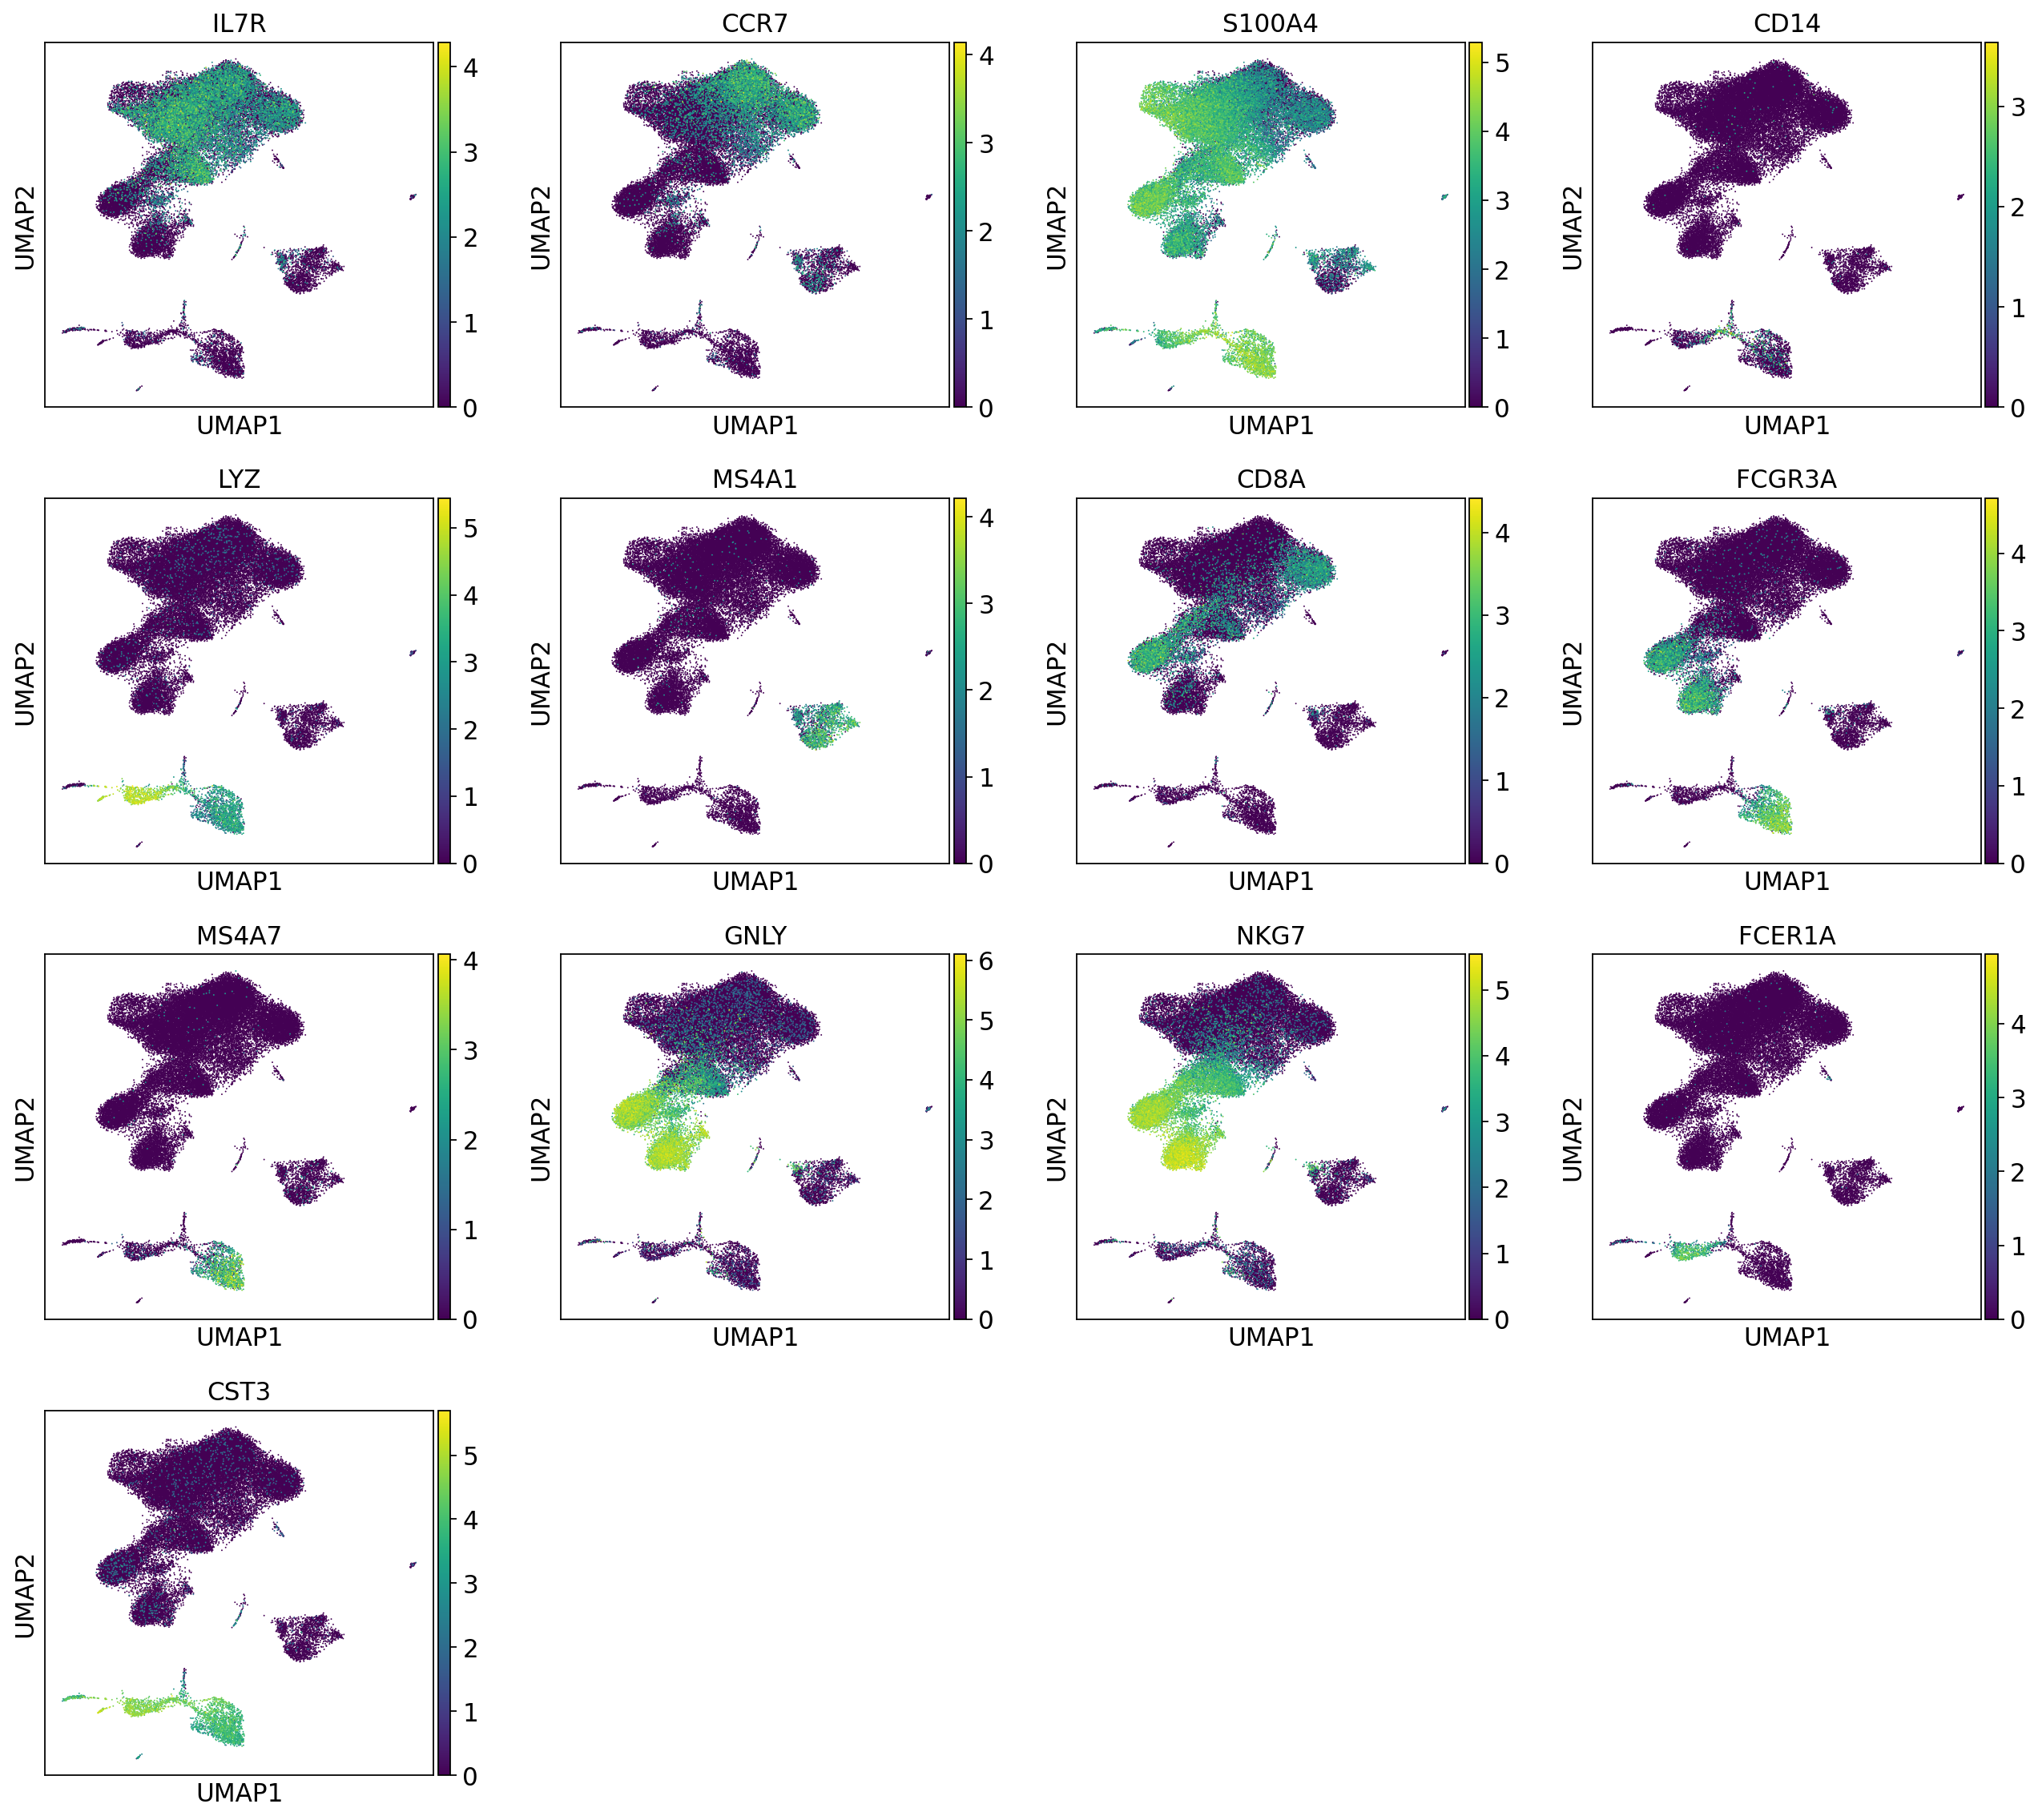

In [206]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

## Find marker genes

ranking genes
    finished (0:00:02)


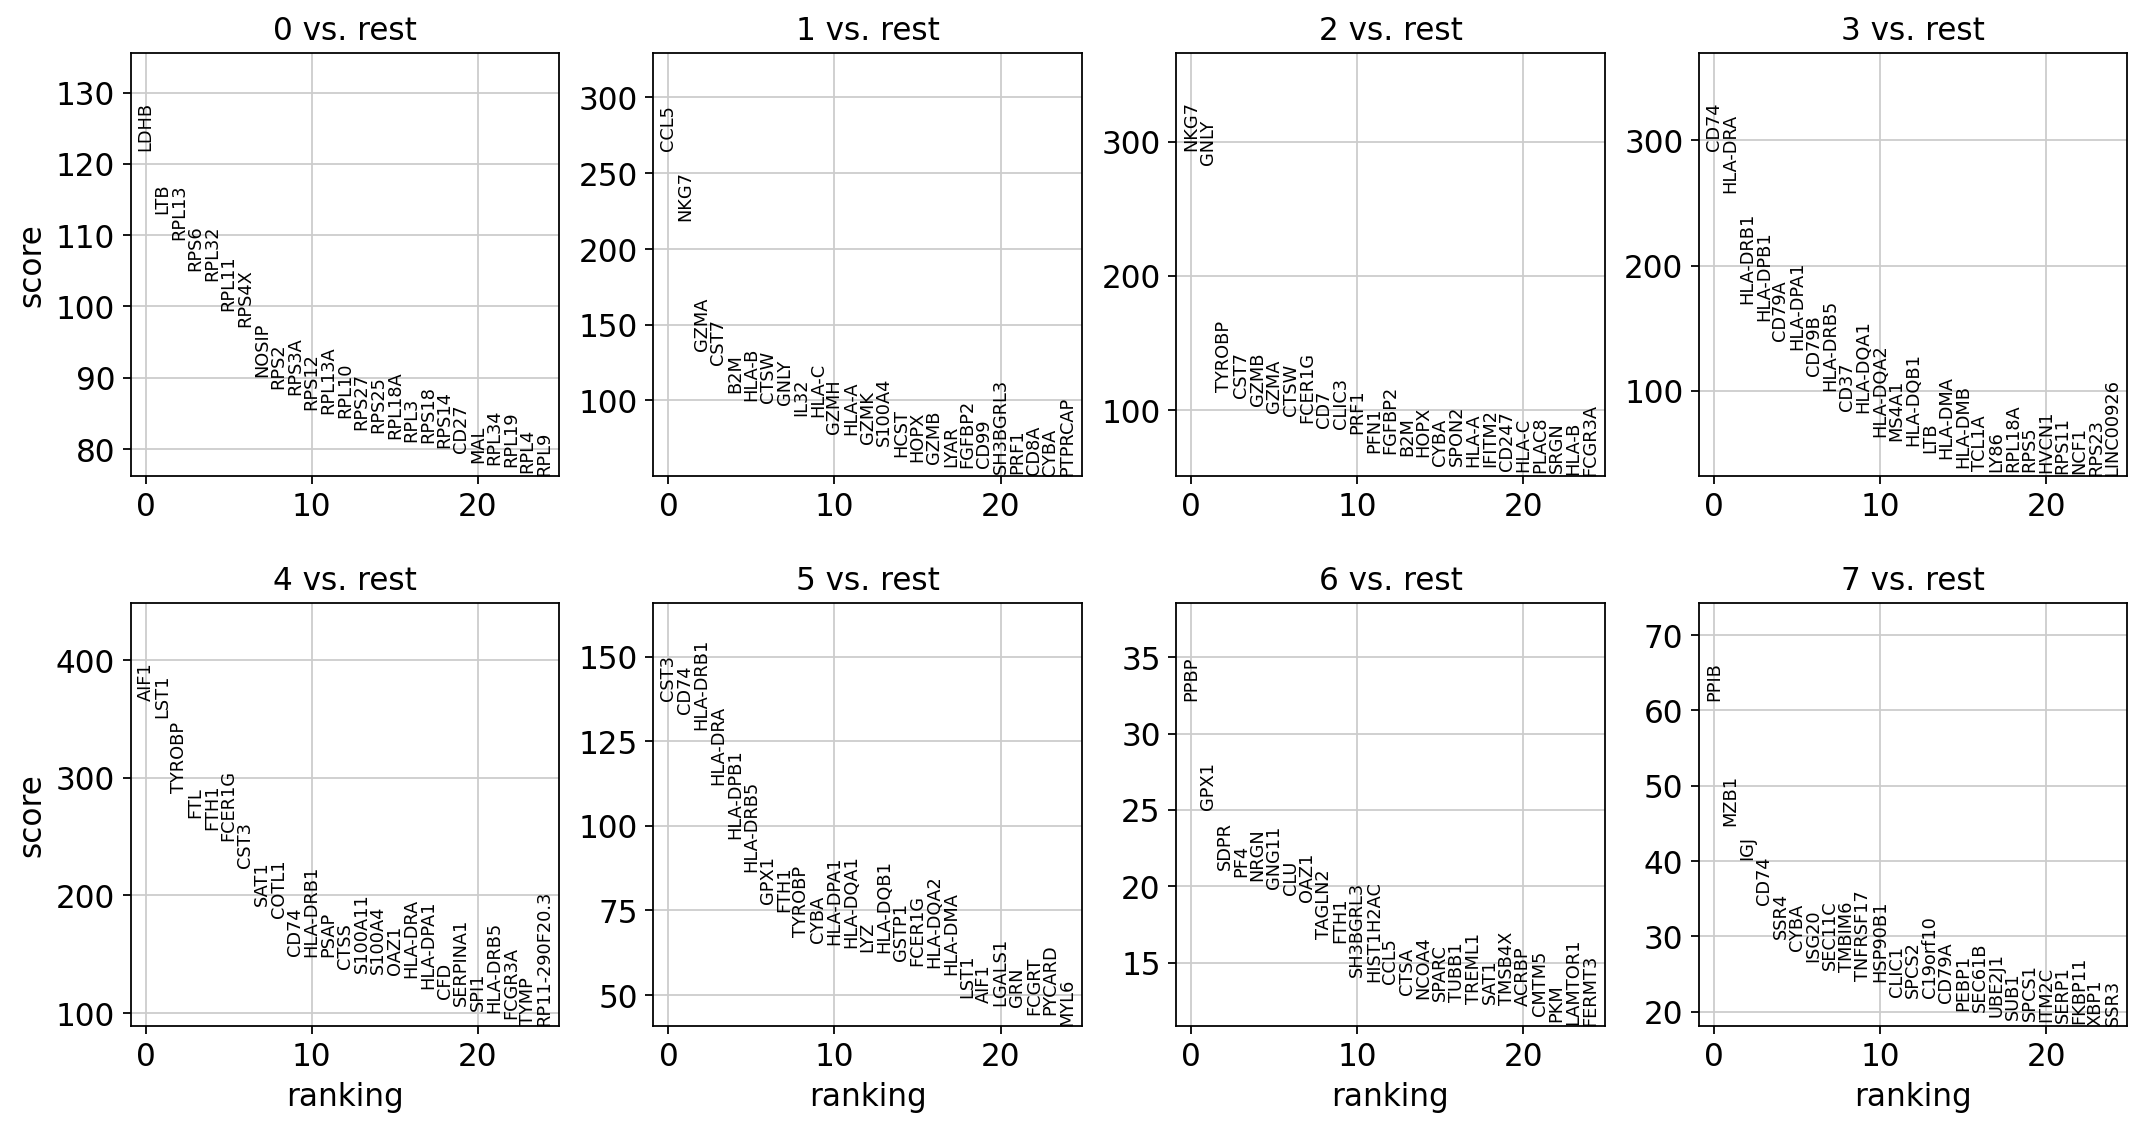

In [224]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)


In [225]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0     1       2         3       4         5     6     7
0   LDHB  CCL5    NKG7      CD74    AIF1      CST3  PPBP  PPIB
1    LTB  NKG7    GNLY   HLA-DRA    LST1      CD74  GPX1  MZB1
2  RPL13  GZMA  TYROBP  HLA-DRB1  TYROBP  HLA-DRB1  SDPR   IGJ
3   RPS6  CST7    CST7  HLA-DPB1     FTL   HLA-DRA   PF4  CD74
4  RPL32   B2M    GZMB     CD79A    FTH1  HLA-DPB1  NRGN  SSR4

In [226]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

0_n  0_p     1_n  1_p     2_n  2_p       3_n  3_p      4_n  4_p  \
0       LDHB  0.0    CCL5  0.0    NKG7  0.0      CD74  0.0     AIF1  0.0   
1        LTB  0.0    NKG7  0.0    GNLY  0.0   HLA-DRA  0.0     LST1  0.0   
2      RPL13  0.0    GZMA  0.0  TYROBP  0.0  HLA-DRB1  0.0   TYROBP  0.0   
3       RPS6  0.0    CST7  0.0    CST7  0.0  HLA-DPB1  0.0      FTL  0.0   
4      RPL32  0.0     B2M  0.0    GZMB  0.0     CD79A  0.0     FTH1  0.0   
...      ...  ...     ...  ...     ...  ...       ...  ...      ...  ...   
16051   CCL5  0.0    CCR7  0.0    CD27  0.0       CD7  0.0      CD7  0.0   
16052   GZMA  0.0    AIF1  0.0   RPL13  0.0      IL32  0.0     IL32  0.0   
16053   CST7  0.0     MAL  0.0    CD3E  0.0      CD3E  0.0     CD3E  0.0   
16054   GNLY  0.0     LTB  0.0     LTB  0.0      CD3D  0.0     CD3D  0.0   
16055   NKG7  0.0  FCER1G  0.0    CD3D  0.0    GIMAP7  0.0  PTPRCAP  0.0   

            5_n            5_p        6_n           6_p      7_n           7_p  
0          CST3   0.000000e+00       PPBP  6.880653e-53     PPIB  3.335699e-61  
1          CD74   0.000000e+00       GPX1  1.065341e-43     MZB1  4.276451e-51  
2      HLA-DRB1   0.000000e+00       SDPR  1.302184e-37      IGJ  3.955147e-48  
3       HLA-DRA   0.000000e+00        PF4  6.545127e-37     CD74  1.704577e-44  
4      HLA-DPB1   0.000000e+00       NRGN  1.655604e-36     SSR4  3.102499e-40  
...         ...            ...        ...           ...      ...           ...  
16051       B2M  1.079969e-305  SETD5-AS1  0.000000e+00   PTGER2  0.000000e+00  
16052       LCK   0.000000e+00    ZDHHC24  0.000000e+00    KLRG1  0.000000e+00  
16053    MALAT1   0.000000e+00      IL2RB  0.000000e+00  TMEM204  0.000000e+00  
16054      CD3D   0.000000e+00      ACAA2  0.000000e+00   SPOCK2  0.000000e+00  
16055      CD3E   0.000000e+00     ECHDC1  0.000000e+00   GIMAP5  0.000000e+00  

[16056 rows x 16 columns]

In [221]:
result['names']['0']

array(['RPL13', 'RPL32', 'LDHB', ..., 'CCL5', 'CYBA', 'NKG7'],
      dtype=object)

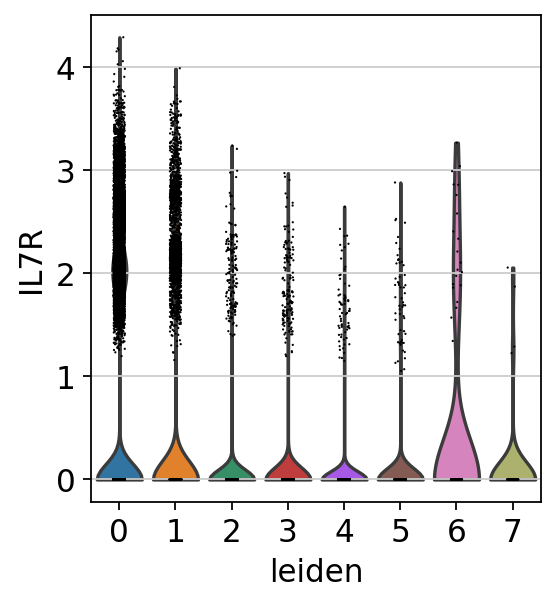

In [211]:
# show expression of some marker genes by group
sc.pl.violin(adata, ['IL7R'], groupby='leiden')


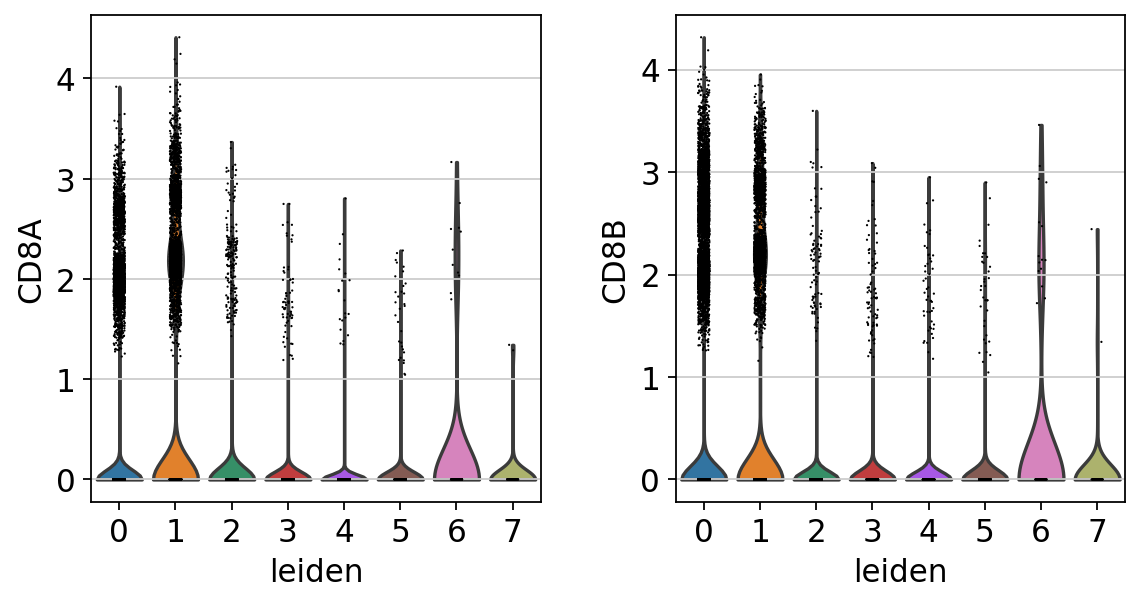

In [213]:
sc.pl.violin(adata, ['CD8A', 'CD8B'], groupby='leiden')


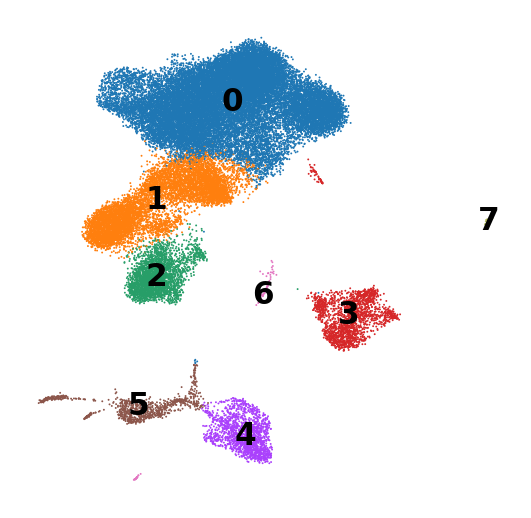

In [227]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
